# Assignment 3 | Problem 2
A new dataset is created, consisting of 15,000 28x28 pixel images of shapes including circles, triangles, and squares.

A seed of `42` is set for reproducibility to keep a constant result.

## Generate dataset

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
import sklearn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

def generate_shapes_dataset(num_samples=15000, img_size=28):
    """
    Generates a dataset of 28x28 images with circles, triangles, and rectangles.
    Returns: (images, labels) where labels are 0=circle, 1=triangle, 2=rectangle.
    """
    images = np.zeros((num_samples, img_size, img_size, 1), dtype=np.float32)
    labels = np.zeros(num_samples, dtype=np.int32)

    for i in range(num_samples):
        # Create a blank image
        img = np.zeros((img_size, img_size), dtype=np.uint8)

        # Randomly choose a shape
        shape_class = np.random.randint(0, 3)
        labels[i] = shape_class

        # Define shape color (white)
        shape_color = 255  # White for 8-bit grayscale

        if shape_class == 0:  # Circle
            center = (random.randint(10, img_size-10), random.randint(10, img_size-10))
            radius = random.randint(5, 10)
            cv2.circle(img, center, radius, shape_color, -1)  # -1 for filled circle

        elif shape_class == 1:  # Triangle
            # Generate random vertices for a triangle
            pt1 = (random.randint(5, img_size-5), random.randint(5, img_size-5))
            pt2 = (random.randint(5, img_size-5), random.randint(5, img_size-5))
            pt3 = (random.randint(5, img_size-5), random.randint(5, img_size-5))

            pts = np.array([pt1, pt2, pt3], np.int32)
            pts = pts.reshape((-1, 1, 2))
            cv2.fillPoly(img, [pts], shape_color)

        else:  # shape_class == 2, Rectangle
            side = random.randint(10, 15)
            top_left_x = random.randint(5, img_size-side-5)
            top_left_y = random.randint(5, img_size-side-5)
            cv2.rectangle(img, (top_left_x, top_left_y),
                          (top_left_x + side, top_left_y + side),
                          shape_color, -1)

        # Normalise to [0, 1] and add channel dimension
        images[i, :, :, 0] = img.astype(np.float32) / 255.0

    return images, labels

Generating dataset...
Dataset shape: (15000, 28, 28, 1)


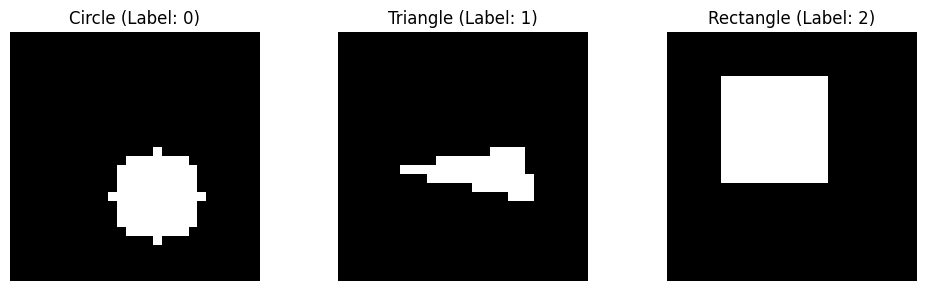

In [2]:
# Call dataset generation
print("Generating dataset...")
X, y = generate_shapes_dataset(15000)
print(f"Dataset shape: {X.shape}")


# Display one sample of each shape
shape_names = ['Circle', 'Triangle', 'Rectangle']
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for i, shape_name in enumerate(shape_names):
    # Find the first occurrence of this shape in the dataset
    idx = np.where(y == i)[0][0]

    # Display the image
    axes[i].imshow(X[idx].squeeze(), cmap='gray')
    axes[i].set_title(f'{shape_name} (Label: {i})')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [3]:
# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = sklearn.model_selection.train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = sklearn.model_selection.train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (10500, 28, 28, 1), Val: (2250, 28, 28, 1), Test: (2250, 28, 28, 1)


## Build VAE Model

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):  # Override
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
# Define encoder
latent_dim = 8 # Small latent dimension for a simple task

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

In [6]:
# Define decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [7]:
## Define VAE model
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    def call(self, inputs):
        # Define the forward pass
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstruction = self.decoder(z)
        return reconstruction

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        x, _ = data  # Unpack the data tuple
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(x, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        x, _ = data
        z_mean, z_log_var, z = self.encoder(x)
        reconstruction = self.decoder(z)
        reconstruction_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.binary_crossentropy(x, reconstruction), axis=(1, 2)
            )
        )
        kl_loss = -0.5 * tf.reduce_mean(tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1))
        total_loss = reconstruction_loss + kl_loss

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

vae = VAE(encoder, decoder)

## Train VAE

In [8]:
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))
history = vae.fit(X_train, X_train, epochs=50, batch_size=128, validation_data=(X_val, X_val))

Epoch 1/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - kl_loss: 5.9893 - loss: 300.3656 - reconstruction_loss: 294.3763 - val_kl_loss: 9.0906 - val_reconstruction_loss: 214.7100 - val_total_loss: 223.8006
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - kl_loss: 8.8113 - loss: 209.1316 - reconstruction_loss: 200.3203 - val_kl_loss: 10.3345 - val_reconstruction_loss: 184.3215 - val_total_loss: 194.6559
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - kl_loss: 11.2582 - loss: 180.8412 - reconstruction_loss: 169.5830 - val_kl_loss: 12.0489 - val_reconstruction_loss: 157.0637 - val_total_loss: 169.1125
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - kl_loss: 12.3925 - loss: 155.3699 - reconstruction_loss: 142.9774 - val_kl_loss: 11.6741 - val_reconstruction_loss: 130.1672 - val_total_loss: 141.8413
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - kl_loss: 14.8540 - loss: 112.8546 - reconstruction_loss: 98.0006 - val_kl_loss: 15.2753 - val_reconstruction_loss: 87.1506 - val_t

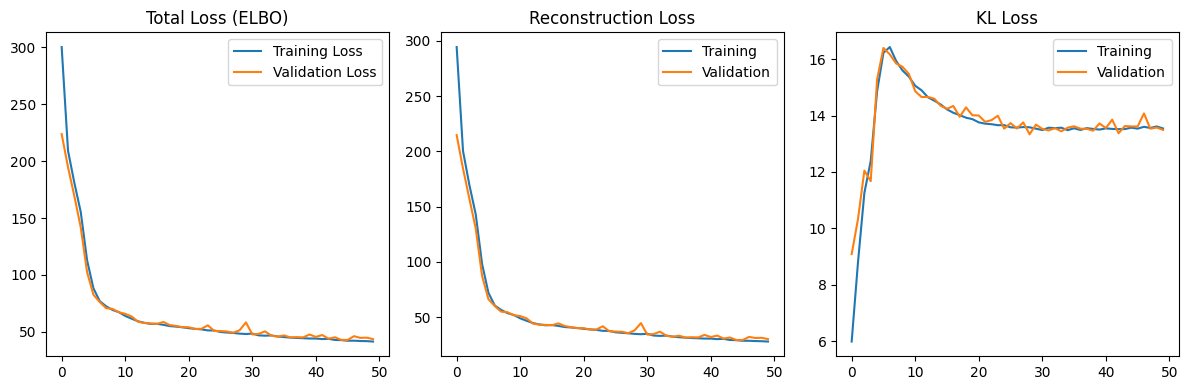

In [9]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_total_loss'], label='Validation Loss')
plt.title('Total Loss (ELBO)')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['reconstruction_loss'], label='Training')
plt.plot(history.history['val_reconstruction_loss'], label='Validation')
plt.title('Reconstruction Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['kl_loss'], label='Training')
plt.plot(history.history['val_kl_loss'], label='Validation')
plt.title('KL Loss')
plt.legend()
plt.tight_layout()
plt.show()